In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import resample
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import Normalizer

from imblearn.pipeline import make_pipeline as make_imblearn_pipeline
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import re
import string
import moralstrength #pls install using pip install moralstrength
import networkx as nx

import spacy
spacy.prefer_gpu()
nlp = spacy.load('en_core_web_sm', disable=["parser", "ner"])
# 
from tqdm import tqdm

### Load Data

In [4]:
df_train = pd.read_csv("../data/balanced/train.csv")
df_test = pd.read_csv("../data/balanced/test.csv")

# #indices for 10-fold cross-validation based on training data
# splits_df = pd.read_csv("../data/cv_splits.csv")


Number of training samples: 10872
Number of positive samples:  5738
Number of negative samples:  5134
   flag                                            content
0     0  My bf (21) and me (22) have been together for ...
1     0  Yesterday afternoon my(19m) aunt's boyfriend b...
2     0  So I've been dating this girl since early dece...
3     0  I like to send my roommate pictures of cute th...
4     0  Good Afternoon, I'm a 29yo US Venezuelan immig...


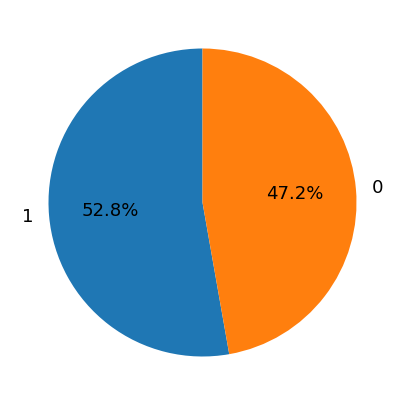

In [5]:
print("Number of training samples: {}".format(len(df_train)))
kwargs = dict(
    startangle = 90,
    fontsize   = 13,
    figsize    = (60,5),
    autopct    = '%1.1f%%',
    label      = ''
)

df_train['flag'].value_counts().plot.pie(**kwargs)

positive_samples = df_train[df_train['flag'] == 1]
negative_samples = df_train[df_train['flag'] == 0]

print("Number of positive samples: ", len(positive_samples))
print("Number of negative samples: ", len(negative_samples))

print(df_train.head())

Number of test samples: 6000
Number of positive samples:  1000
Number of negative samples:  5000


<Axes: >

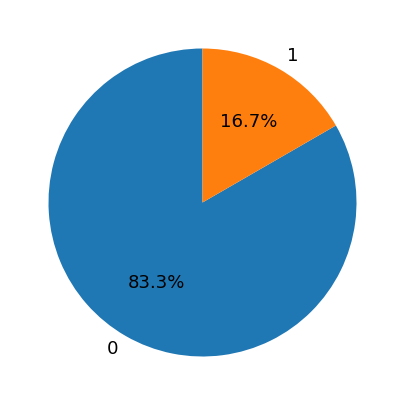

In [6]:
print("Number of test samples: {}".format(len(df_test)))
positive_samples = df_test[df_test['flag'] == 1]
negative_samples = df_test[df_test['flag'] == 0]

print("Number of positive samples: ", len(positive_samples))
print("Number of negative samples: ", len(negative_samples))

df_test['flag'].value_counts().plot.pie(**kwargs)


## Text Preprocessing

In [7]:
#handling clitics
def pre_normalize_sentence(text):
    contractions = {
        # r'[\(\[].*?[\)\]]': ' ',  # Remove all words in brackets
        r"(n\'t)": " not",  # Resolve contraction "-n't"
        r"(\'ve)": " have",  # Resolve contraction "-'ve"
        r"(\'ll)": " will",  # Resolve contraction "-'ll"
        r"(\'s)": " is",  # Resolve contraction "-'s"
        r"(\'m)": " am",  # Resolve contraction "-'m"
        r"(\'d)": " would",  # Resolve contraction "-'d"
        r"(\'re)": " are",  # Resolve contraction "-'re"
    }
    for pattern, replacement in contractions.items():
        text = re.sub(pattern, replacement, text)
    return text

In [8]:
def normalize_sentence(s):
    s = s.lower()                                                   # Lowercase whole sentence
    s = re.sub(r'\s+', ' ', s)                                      # Remove duplicate whitespaces
    s = re.sub(r'([.]){2,}', ' ', s)                                # Remove ellipses ...
    s = re.sub(r'([\w.-]+)([,;])([\w.-]+)', '\g<1>\g<2> \g<3>', s)  # Add missing whitespace after , and ;
    s = re.sub(r'(.+)\1{2,}', '\g<1>\g<1>', s)                      # Reduce repeated sequences to 2
    s = re.sub(r'\s+', ' ', s)                                      # Remove duplicate whitespaces (again)
    s = s.strip()                                                   # Remove trailing whitespaces
    return s

In [9]:
#splitting each post into sentences
def read_post(text):
    # Tokenize the text into sentences
    sentences = sent_tokenize(text)
    return sentences

def sentence_similarity(sent1, sent2, stopwords=None):

    # Create a set of all unique words in both sentences
    all_words = list(set(sent1 + sent2))

    # Create vectors to represent each sentence
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)

    # Count word occurrences
    for word in sent1:
        vector1[all_words.index(word)] += 1

    for word in sent2:
        vector2[all_words.index(word)] += 1

    # Calculate cosine similarity
    return 1 - cosine_distance(vector1, vector2)

def build_similarity_matrix(sentences, stopwords):
    # Create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))

    # Fill the similarity matrix with cosine similarity scores
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2:
                continue
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stopwords)

    return similarity_matrix

def generate_summary(text, top_n=5):
    # Load English stopwords
    stop_words = stopwords.words('english')

    # Tokenize the text into sentences
    sentences = read_post(text)

    # Generate the sentence similarity matrix
    sentence_similarity_matrix = build_similarity_matrix(sentences, stop_words)

    # Convert the similarity matrix into a graph
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_matrix)

    # Apply the PageRank algorithm to rank the sentences
    scores = nx.pagerank(sentence_similarity_graph, max_iter=200)

    # Sort the sentences by their scores
    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)

    # Extract the top sentences as the summary
    summary = [sentence for score, sentence in ranked_sentences[:top_n]]

    while len(summary) < top_n:
      summary.append('')

    return summary

def split_into_sentences(post_df):
    sent1 = []
    sent2 = []
    sent3 = []
    sent4 = []
    sent5 = []
    index = 0
        
    for i, content in enumerate(post_df['content']):
        array_summary = generate_summary(content)
        sent1.append(array_summary[0])
        sent2.append(array_summary[1])
        sent3.append(array_summary[2])
        sent4.append(array_summary[3])
        sent5.append(array_summary[4])
        index = i
    
    post_df['sent1'] = sent1
    post_df['sent2'] = sent2
    post_df['sent3'] = sent3
    post_df['sent4'] = sent4
    post_df['sent5'] = sent5

    # To rearrange the order of sentences as specified (1.1, 1.2, ..., 1.5, then 2.1, ..., 2.5, etc.),
    # we can first transpose the DataFrame and then use the same approach to melt it into a single column.
    
    # Transposing the original DataFrame so that each sentence sequence becomes a row
    post_df_transposed = post_df[['sent1', 'sent2', 'sent3', 'sent4', 'sent5']].T
    
    # Resetting the index since after transposition, the original column names become the index
    post_df_transposed.reset_index(drop=True, inplace=True)
    
    # Melting the transposed DataFrame without considering variable names, just values
    df_long_transposed = pd.melt(post_df_transposed, value_name="content")["content"]
    
    # Converting the Series into a DataFrame
    df_ordered = df_long_transposed.to_frame().reset_index(drop=True)
    
    return df_ordered

In [10]:
## Combined preprocessing pipeline
#pipeline using spaCy with lemmatization, stopword and punctuation removal
def preprocess_spacy(posts, moral='No'):
    preprocessed_data = []
    
    # Assuming 'sentences' is a pandas Series or similar iterable of strings
    for post in posts:
        # print(post)
        pre_normal_post = pre_normalize_sentence(post)
        normalized_post = normalize_sentence(pre_normal_post)
        # cleaned_post = normalized_post.replace('\n\n', '').replace('\n', '')
        doc = nlp(normalized_post)
        if moral == 'No':
            preprocessed_tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
        else:
            preprocessed_tokens = [token for token in doc if not token.is_stop and not token.is_punct]
        preprocessed_data.append(preprocessed_tokens)

    return preprocessed_data


## Classification Models

### Naive Bayes Classifier (processing whole text, and text split into sentences)

##### Using only handcrafted features

In [12]:
X_nb = df_train['content'].copy()
y_nb = df_train['flag'].copy()

# Initialize the StratifiedKFold class
n_splits = 3  # Or however many folds you want
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

val_f1s = []
preprocess_pipeline = preprocess_spacy
counter = 1
for train_index, test_index in skf.split(X_nb, y_nb):
    print("Loop ", counter)
    X_train_nb, X_val_nb = X_nb[train_index], X_nb[test_index]
    y_train_nb, y_val_nb = y_nb[train_index], y_nb[test_index]

    ## Adding handcrafted features using lexicon
    preprocessed_spacy_train = preprocess_pipeline(X_train_nb, moral='Yes')
    result = moralstrength.estimate_morals(preprocessed_spacy_train, process=False) # set to false if text is alredy pre-processed
    print(len(result))
    for column in result.columns:
        print(f"{column} column for training data has {result[column].isnull().sum()} null values")
        result[column] = (result[column]-1)/8 #normalize score to 0 to 1
        result[column] = result[column].fillna(0.5) #assign moral score of -1 to null values
    result['moral_score'] = result.mean(axis=1) #normalize score to 0 to 1
    print(result.head())      
    X_train_nb_vec = csr_matrix(result.values)

    preprocessed_spacy_val = preprocess_pipeline(X_val_nb, moral='Yes')
    result_val = moralstrength.estimate_morals(preprocessed_spacy_val, process=False) # set to false if text is alredy pre-processed
    print(len(result_val))
    # result_val['moral_score'] = result_val.mean(axis=1) #normalize score to 0 to 1
    for column in result_val.columns:
        print(f"{column} column for validation data has {result_val[column].isnull().sum()} null values")
        result_val[column] = (result_val[column]-1)/8 #normalize score to 0 to 1
        result_val[column] = result_val[column].fillna(0.5) #assign moral score of -1 to null values
        # print(result_val[column][0:5])
    result_val['moral_score'] = result_val.mean(axis=1) #normalize score to 0 to 1
    print(result_val.head())
    X_val_nb_vec = csr_matrix(result_val.values)

    # Initialize the Bernoulli Naive Bayes model
    model = BernoulliNB()

    # Fit the model
    model.fit(X_train_nb_vec, y_train_nb)

    # Predict on the test set
    y_pred_nb = model.predict(X_val_nb_vec)

    val_f1s.append(f1_score(y_val_nb, y_pred_nb))
    counter+=1

# Calculate and print the average F1 score across all validation folds
# print(f"Results for {preprocessor}:")
print("Cross-Validation F1 scores: ", val_f1s)
print(f"Average Cross-Validation F1 Score: {np.mean(val_f1s):.3f}\n")

Loop  1
7248
care column for training data has 2514 null values
fairness column for training data has 2999 null values
loyalty column for training data has 3498 null values
authority column for training data has 1333 null values
purity column for training data has 2982 null values
       care  fairness  loyalty  authority    purity  moral_score
0  0.000000  0.895833   0.3125   0.833333  0.544643     0.517262
1  0.202083  0.500000   0.5000   0.595238  0.546875     0.468839
2  0.975000  0.895833   0.5000   0.500000  0.875000     0.749167
3  0.500000  0.500000   0.5000   0.500000  0.500000     0.500000
4  0.500000  0.895833   0.5000   0.833333  0.500000     0.645833
3624
care column for validation data has 1250 null values
fairness column for validation data has 1483 null values
loyalty column for validation data has 1744 null values
authority column for validation data has 632 null values
purity column for validation data has 1530 null values
       care  fairness   loyalty  authority   

In [13]:
X_train_NB_handcrafted = df_train['content'].copy()
y_train_NB_handcrafted = df_train['flag'].copy()
X_test_NB_handcrafted = df_test['content'].copy()
y_test_NB_handcrafted = df_test['flag'].copy()

#using preprocess_pipeline as vectorizer
preprocess_pipeline = preprocess_spacy
# vectorizer = TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,)

## Adding handcrafted features using lexicon
preprocessed_spacy_train = preprocess_pipeline(X_train_NB_handcrafted, moral='Yes')
result = moralstrength.estimate_morals(preprocessed_spacy_train, process=False) # set to false if text is alredy pre-processed
print(len(result))
for column in result.columns:
    print(f"{column} column for training data has {result[column].isnull().sum()} null values")
    result[column] = (result[column]-1)/8 #normalize score to 0 to 1
    result[column] = result[column].fillna(0.5) #assign moral score of -1 to null values
result['moral_score'] = result.mean(axis=1) #normalize score to 0 to 1
print(result.head())
X_train_NB_handcrafted_vec = csr_matrix(result.values)

preprocessed_spacy_test = preprocess_pipeline(X_test_NB_handcrafted, moral='Yes')
result_test = moralstrength.estimate_morals(preprocessed_spacy_test, process=False) # set to false if text is alredy pre-processed
# result_val['moral_score'] = result_val.mean(axis=1) #normalize score to 0 to 1
for column in result_test.columns:
    print(f"{column} column for test data has {result[column].isnull().sum()} null values")
    result_test[column] = (result_test[column]-1)/8 #normalize score to 0 to 1
    result_test[column] = result_test[column].fillna(0.5) #assign moral score of -1 to null values
    # print(result_val[column][0:5])
result_test['moral_score'] = result_test.mean(axis=1) #normalize score to 0 to 1
print(result_test.head())
X_test_NB_handcrafted_vec = csr_matrix(result_test.values)

model_NB_handcrafted = BernoulliNB()
model_NB_handcrafted.fit(X_train_NB_handcrafted_vec, y_train_NB_handcrafted)

y_pred_NB_handcrafted = model_NB_handcrafted.predict(X_test_NB_handcrafted_vec)
test_f1_score_nb_handcrafted = f1_score(y_test_NB_handcrafted, y_pred_NB_handcrafted)

print(f"Final Test F1 Score for Naive Bayes: {test_f1_score_nb_handcrafted:.3f}")


10872
care column for training data has 3764 null values
fairness column for training data has 4482 null values
loyalty column for training data has 5242 null values
authority column for training data has 1965 null values
purity column for training data has 4512 null values
       care  fairness   loyalty  authority    purity  moral_score
0  0.000000  0.895833  0.312500   0.833333  0.544643     0.517262
1  0.202083  0.500000  0.500000   0.595238  0.546875     0.468839
2  0.975000  0.895833  0.500000   0.500000  0.875000     0.749167
3  0.227183  0.458333  0.291667   0.500000  0.500000     0.395437
4  0.675000  0.500000  0.760204   0.698214  0.652778     0.657239
care column for test data has 0 null values
fairness column for test data has 0 null values
loyalty column for test data has 0 null values
authority column for test data has 0 null values
purity column for test data has 0 null values
       care  fairness   loyalty  authority    purity  moral_score
0  0.346667  0.500000  0.8750

##### Naive Bayes with only td-idf vectors

In [13]:
X_nb = df_train['content'].copy()
y_nb = df_train['flag'].copy()

# Initialize the StratifiedKFold class
n_splits = 3  # Or however many folds you want
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define preprocessing and vectorization configurations
preprocessing_type = {
    'spacy_tfidf': (preprocess_spacy, TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,)),
    # 'spacy_sentences': (preprocess_spacy_moral_sentences, TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,))
}

for preprocessor, (preprocess_pipeline, vectorizer) in preprocessing_type.items():
    val_f1s = []
    print(preprocessor)
    for train_index, test_index in skf.split(X_nb, y_nb):
        X_train_nb, X_val_nb = X_nb[train_index], X_nb[test_index]
        y_train_nb, y_val_nb = y_nb[train_index], y_nb[test_index]

        # Apply preprocessing if specified
        if preprocess_pipeline:
            X_train_nb_preprocessed = preprocess_pipeline(X_train_nb)
            X_val_nb_preprocessed = preprocess_pipeline(X_val_nb)
        # Vectorize data
        X_train_nb_vec = vectorizer.fit_transform(X_train_nb_preprocessed)
        X_val_nb_vec = vectorizer.transform(X_val_nb_preprocessed)

        # Initialize the Bernoulli Naive Bayes model
        model = BernoulliNB()

        # Fit the model
        model.fit(X_train_nb_vec, y_train_nb)

        # Predict on the test set
        y_pred_nb = model.predict(X_val_nb_vec)

        val_f1s.append(f1_score(y_val_nb, y_pred_nb))

    # Calculate and print the average F1 score across all validation folds
    print(f"Results for {preprocessor}:")
    print(f"Average Cross-Validation F1 Score: {np.mean(val_f1s):.3f}\n")

spacy_tfidf


/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Results for spacy_tfidf:
Average Cross-Validation F1 Score: 0.737



In [14]:
X_train_NB_tfidf = df_train['content'].copy()
y_train_NB_tfidf = df_train['flag'].copy()
X_test_NB_tfidf = df_test['content'].copy()
y_test_NB_tfidf = df_test['flag'].copy()

#using preprocess_pipeline as vectorizer
preprocess_pipeline = preprocess_spacy
# vectorizer = TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,)

#preprocess
X_train_NB_tfidf = preprocess_pipeline(X_train_NB_tfidf)
X_test_NB_tfidf = preprocess_pipeline(X_test_NB_tfidf)

print(len(X_train_NB_tfidf))
# Vectorize data
X_train_NB_tfidf_vec = vectorizer.fit_transform(X_train_NB_tfidf)
X_test_NB_tfidf_vec = vectorizer.transform(X_test_NB_tfidf)
print(X_train_NB_tfidf_vec.shape)

model_NB_tfidf = BernoulliNB()
model_NB_tfidf.fit(X_train_NB_tfidf_vec, y_train_NB_tfidf)

y_pred_NB_tfidf = model_NB_tfidf.predict(X_test_NB_tfidf_vec)
test_f1_score_nb_tfidf = f1_score(y_test_NB_tfidf, y_pred_NB_tfidf)

print(f"Final Test F1 Score for Naive Bayes (td-idf vectors): {test_f1_score_nb_tfidf:.3f}")


10872


/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(10872, 29808)
Final Test F1 Score for Naive Bayes (td-idf vectors): 0.475


##### Naive Bayes with both td-idf vectors and additional handcrafted features of moral_score from morality lexicon

In [10]:
X_nb = df_train['content'].copy()
y_nb = df_train['flag'].copy()

# Initialize the StratifiedKFold class
n_splits = 3  # Or however many folds you want
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define preprocessing and vectorization configurations
preprocessing_type = {
    'spacy_tfidf': (preprocess_spacy, TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,)),
    # 'spacy_sentences': (preprocess_spacy_moral_sentences, TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,))

}

for preprocessor, (preprocess_pipeline, vectorizer) in preprocessing_type.items():
    val_f1s = []
    counter = 1
    for train_index, test_index in skf.split(X_nb, y_nb):
        print("Loop ", counter)
        X_train_nb, X_val_nb = X_nb[train_index], X_nb[test_index]
        y_train_nb, y_val_nb = y_nb[train_index], y_nb[test_index]

        X_train_nb_preprocessed = preprocess_pipeline(X_train_nb)
        X_val_nb_preprocessed = preprocess_pipeline(X_val_nb)

        # Vectorize data
        X_train_nb_vec = vectorizer.fit_transform(X_train_nb_preprocessed)
        X_val_nb_vec = vectorizer.transform(X_val_nb_preprocessed)


        ## Adding handcrafted features using lexicon
        preprocessed_spacy_train = preprocess_pipeline(X_train_nb, moral='Yes')
        result = moralstrength.estimate_morals(preprocessed_spacy_train, process=False) # set to false if text is alredy pre-processed
        # result['moral_score'] = result.mean(axis=1) #normalize score to 0 to 1
        print(len(result))
        for column in result.columns:
            print(f"{column} column for training data has {result[column].isnull().sum()} null values")
            result[column] = (result[column]-1)/8 #normalize score to 0 to 1
            result[column] = result[column].fillna(0.5) #assign moral score of -1 to null values
        result['moral_score'] = result.mean(axis=1) #normalize score to 0 to 1
        result_moral_matrix = csr_matrix((result['moral_score']).values.reshape(-1, 1)) # Reshape if necessary
        X_train_nb_vec = hstack([X_train_nb_vec, result_moral_matrix])

        preprocessed_spacy_val = preprocess_pipeline(X_val_nb, moral='Yes')
        result_val = moralstrength.estimate_morals(preprocessed_spacy_val, process=False) # set to false if text is alredy pre-processed
        print(len(result_val))
        for column in result_val.columns:
            print(f"{column} column for training data has {result_val[column].isnull().sum()} null values")
            result_val[column] = (result_val[column]-1)/8 #normalize score to 0 to 1
            result_val[column] = result_val[column].fillna(0.5) #assign moral score of -1 to null values
        result_val['moral_score'] = result_val.mean(axis=1) #normalize score to 0 to 1
        result_moral_matrix_val = csr_matrix((result_val['moral_score']).values.reshape(-1, 1))
        X_val_nb_vec = hstack([X_val_nb_vec, result_moral_matrix_val])

        # Initialize the Bernoulli Naive Bayes model
        model = BernoulliNB()

        # Fit the model
        model.fit(X_train_nb_vec, y_train_nb)

        # Predict on the test set
        y_pred_nb = model.predict(X_val_nb_vec)

        val_f1s.append(f1_score(y_val_nb, y_pred_nb))
        counter+=1

    # Calculate and print the average F1 score across all validation folds
    print(f"Results for {preprocessor}:")
    print(f"Average Cross-Validation F1 Score: {np.mean(val_f1s):.3f}\n")

Loop  1


/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


7248
care column for training data has 2514 null values
fairness column for training data has 2999 null values
loyalty column for training data has 3498 null values
authority column for training data has 1333 null values
purity column for training data has 2982 null values
3624
care column for training data has 1250 null values
fairness column for training data has 1483 null values
loyalty column for training data has 1744 null values
authority column for training data has 632 null values
purity column for training data has 1530 null values
Loop  2


/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


7248
care column for training data has 2475 null values
fairness column for training data has 2987 null values
loyalty column for training data has 3495 null values
authority column for training data has 1314 null values
purity column for training data has 2998 null values
3624
care column for training data has 1289 null values
fairness column for training data has 1495 null values
loyalty column for training data has 1747 null values
authority column for training data has 651 null values
purity column for training data has 1514 null values
Loop  3


/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


7248
care column for training data has 2539 null values
fairness column for training data has 2978 null values
loyalty column for training data has 3491 null values
authority column for training data has 1283 null values
purity column for training data has 3044 null values
3624
care column for training data has 1225 null values
fairness column for training data has 1504 null values
loyalty column for training data has 1751 null values
authority column for training data has 682 null values
purity column for training data has 1468 null values
Results for spacy_tfidf:
Average Cross-Validation F1 Score: 0.737



In [13]:
X_train_NB_overall = df_train['content'].copy()
y_train_NB_overall = df_train['flag'].copy()
X_test_NB_overall = df_test['content'].copy()
y_test_NB_overall = df_test['flag'].copy()

#using preprocess_pipeline as vectorizer
preprocess_pipeline = preprocess_spacy
# vectorizer = TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,)

#preprocess
X_train_NB_overall_processed = preprocess_pipeline(X_train_NB_overall)
X_test_NB_overall_processed = preprocess_pipeline(X_test_NB_overall)

print(X_train_NB_overall.head())

# Vectorize data
X_train_NB_overall_vec = vectorizer.fit_transform(X_train_NB_overall_processed)
X_test_NB_overall_vec = vectorizer.transform(X_test_NB_overall_processed)
print(X_train_NB_overall_vec.shape)

 ## Adding handcrafted features using lexicon
preprocessed_spacy_train = preprocess_pipeline(X_train_NB_overall, moral='Yes')
result = moralstrength.estimate_morals(preprocessed_spacy_train, process=False) # set to false if text is alredy pre-processed
# result['moral_score'] = result.mean(axis=1) #normalize score to 0 to 1
print(len(result))
for column in result.columns:
    print(f"{column} column for training data has {result[column].isnull().sum()} null values")
    result[column] = (result[column]-1)/8 #normalize score to 0 to 1
    result[column] = result[column].fillna(0.5) #assign moral score of -1 to null values
result['moral_score'] = result.mean(axis=1) #normalize score to 0 to 1
result_moral_matrix = csr_matrix((result['moral_score']).values.reshape(-1, 1)) # Reshape if necessary
X_train_nb_overall_vec = hstack([X_train_NB_overall_vec, result_moral_matrix])

preprocessed_spacy_val = preprocess_pipeline(X_test_NB_overall, moral='Yes')
result_test = moralstrength.estimate_morals(preprocessed_spacy_val, process=False) # set to false if text is alredy pre-processed
print(len(result_val))
for column in result_test.columns:
    print(f"{column} column for training data has {result_test[column].isnull().sum()} null values")
    result_test[column] = (result_test[column]-1)/8 #normalize score to 0 to 1
    result_test[column] = result_test[column].fillna(0.5) #assign moral score of -1 to null values
result_test['moral_score'] = result_test.mean(axis=1) #normalize score to 0 to 1
result_moral_matrix_test = csr_matrix((result_test['moral_score']).values.reshape(-1, 1))
X_test_nb_overall_vec = hstack([X_test_NB_overall_vec, result_moral_matrix_test])

model_NB_overall = BernoulliNB()
model_NB_overall.fit(X_train_nb_overall_vec, y_train_NB_overall)

y_pred_NB_overall = model_NB_overall.predict(X_test_nb_overall_vec)
test_f1_score_nb_overall = f1_score(y_test_NB_overall, y_pred_NB_overall)

print(f"Final Test F1 Score for Naive Bayes: {test_f1_score_nb_overall:.3f}")


0    My bf (21) and me (22) have been together for ...
1    Yesterday afternoon my(19m) aunt's boyfriend b...
2    So I've been dating this girl since early dece...
3    I like to send my roommate pictures of cute th...
4    Good Afternoon, I'm a 29yo US Venezuelan immig...
Name: content, dtype: object
(10872, 29808)
10872
care column for training data has 3764 null values
fairness column for training data has 4482 null values
loyalty column for training data has 5242 null values
authority column for training data has 1965 null values
purity column for training data has 4512 null values
3624
care column for training data has 1682 null values
fairness column for training data has 2130 null values
loyalty column for training data has 2484 null values
authority column for training data has 811 null values
purity column for training data has 2050 null values
Final Test F1 Score for Naive Bayes: 0.475


### Logistic Regression

##### Using only handcrafted features

In [14]:
X_lr = df_train['content'].copy()
y_lr = df_train['flag'].copy()

# Initialize the StratifiedKFold class
n_splits = 3  # Or however many folds you want
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

val_f1s = []
preprocess_pipeline = preprocess_spacy
counter = 1
for train_index, test_index in skf.split(X_lr, y_lr):
    print("Loop ", counter)
    X_train_lr, X_val_lr = X_lr[train_index], X_lr[test_index]
    y_train_lr, y_val_lr = y_lr[train_index], y_lr[test_index]

    ## Adding handcrafted features using lexicon
    preprocessed_spacy_train = preprocess_pipeline(X_train_lr, moral='Yes')
    result = moralstrength.estimate_morals(preprocessed_spacy_train, process=False) # set to false if text is alredy pre-processed
    print(len(result))
    for column in result.columns:
        print(f"{column} column for training data has {result[column].isnull().sum()} null values")
        result[column] = (result[column]-1)/8 #normalize score to 0 to 1
        result[column] = result[column].fillna(0.5) #assign moral score of -1 to null values
    result['moral_score'] = result.mean(axis=1) #normalize score to 0 to 1
    print(result.head())      
    X_train_lr_vec = csr_matrix(result.values)

    preprocessed_spacy_val = preprocess_pipeline(X_val_lr, moral='Yes')
    result_val = moralstrength.estimate_morals(preprocessed_spacy_val, process=False) # set to false if text is alredy pre-processed
    print(len(result_val))
    # result_val['moral_score'] = result_val.mean(axis=1) #normalize score to 0 to 1
    for column in result_val.columns:
        print(f"{column} column for validation data has {result_val[column].isnull().sum()} null values")
        result_val[column] = (result_val[column]-1)/8 #normalize score to 0 to 1
        result_val[column] = result_val[column].fillna(0.5) #assign moral score of -1 to null values
        # print(result_val[column][0:5])
    result_val['moral_score'] = result_val.mean(axis=1) #normalize score to 0 to 1
    print(result_val.head())
    X_val_lr_vec = csr_matrix(result_val.values)

    # Initialize the Bernoulli Naive Bayes model
    model = LogisticRegression(solver='saga')

    # Fit the model
    model.fit(X_train_lr_vec, y_train_lr)

    # Predict on the test set
    y_pred_lr = model.predict(X_val_lr_vec)

    val_f1s.append(f1_score(y_val_lr, y_pred_lr))
    counter+=1

# Calculate and print the average F1 score across all validation folds
# print(f"Results for {preprocessor}:")
print("Cross-Validation F1 scores: ", val_f1s)
print(f"Average Cross-Validation F1 Score: {np.mean(val_f1s):.3f}\n")

Loop  1
7248
care column for training data has 2514 null values
fairness column for training data has 2999 null values
loyalty column for training data has 3498 null values
authority column for training data has 1333 null values
purity column for training data has 2982 null values
       care  fairness  loyalty  authority    purity  moral_score
0  0.000000  0.895833   0.3125   0.833333  0.544643     0.517262
1  0.202083  0.500000   0.5000   0.595238  0.546875     0.468839
2  0.975000  0.895833   0.5000   0.500000  0.875000     0.749167
3  0.500000  0.500000   0.5000   0.500000  0.500000     0.500000
4  0.500000  0.895833   0.5000   0.833333  0.500000     0.645833
3624
care column for validation data has 1250 null values
fairness column for validation data has 1483 null values
loyalty column for validation data has 1744 null values
authority column for validation data has 632 null values
purity column for validation data has 1530 null values
       care  fairness   loyalty  authority   

/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


7248
care column for training data has 2475 null values
fairness column for training data has 2987 null values
loyalty column for training data has 3495 null values
authority column for training data has 1314 null values
purity column for training data has 2998 null values
       care  fairness   loyalty  authority    purity  moral_score
0  0.000000  0.895833  0.312500   0.833333  0.544643     0.517262
1  0.227183  0.458333  0.291667   0.500000  0.500000     0.395437
2  0.675000  0.500000  0.760204   0.698214  0.652778     0.657239
3  0.500000  0.895833  0.500000   0.833333  0.500000     0.645833
4  0.500000  0.500000  0.500000   0.642262  0.500000     0.528452
3624
care column for validation data has 1289 null values
fairness column for validation data has 1495 null values
loyalty column for validation data has 1747 null values
authority column for validation data has 651 null values
purity column for validation data has 1514 null values
       care  fairness  loyalty  authority    pu

/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


7248
care column for training data has 2539 null values
fairness column for training data has 2978 null values
loyalty column for training data has 3491 null values
authority column for training data has 1283 null values
purity column for training data has 3044 null values
       care  fairness   loyalty  authority    purity  moral_score
0  0.202083  0.500000  0.500000   0.595238  0.546875     0.468839
1  0.975000  0.895833  0.500000   0.500000  0.875000     0.749167
2  0.227183  0.458333  0.291667   0.500000  0.500000     0.395437
3  0.675000  0.500000  0.760204   0.698214  0.652778     0.657239
4  0.500000  0.500000  0.500000   0.500000  0.500000     0.500000
3624
care column for validation data has 1225 null values
fairness column for validation data has 1504 null values
loyalty column for validation data has 1751 null values
authority column for validation data has 682 null values
purity column for validation data has 1468 null values
    care  fairness  loyalty  authority    purit

/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [15]:
X_train_LR_handcrafted = df_train['content'].copy()
y_train_LR_handcrafted = df_train['flag'].copy()
X_test_LR_handcrafted = df_test['content'].copy()
y_test_LR_handcrafted = df_test['flag'].copy()

#using preprocess_pipeline as vectorizer
preprocess_pipeline = preprocess_spacy
# vectorizer = TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,)

## Adding handcrafted features using lexicon
preprocessed_spacy_train = preprocess_pipeline(X_train_LR_handcrafted, moral='Yes')
result = moralstrength.estimate_morals(preprocessed_spacy_train, process=False) # set to false if text is alredy pre-processed
print(len(result))
for column in result.columns:
    print(f"{column} column for training data has {result[column].isnull().sum()} null values")
    result[column] = (result[column]-1)/8 #normalize score to 0 to 1
    result[column] = result[column].fillna(0.5) #assign moral score of -1 to null values
result['moral_score'] = result.mean(axis=1) #normalize score to 0 to 1
print(result.head())
X_train_LR_handcrafted_vec = csr_matrix(result.values)

preprocessed_spacy_test = preprocess_pipeline(X_test_LR_handcrafted, moral='Yes')
result_test = moralstrength.estimate_morals(preprocessed_spacy_test, process=False) # set to false if text is alredy pre-processed
# result_val['moral_score'] = result_val.mean(axis=1) #normalize score to 0 to 1
for column in result_test.columns:
    print(f"{column} column for test data has {result[column].isnull().sum()} null values")
    result_test[column] = (result_test[column]-1)/8 #normalize score to 0 to 1
    result_test[column] = result_test[column].fillna(0.5) #assign moral score of -1 to null values
    # print(result_val[column][0:5])
result_test['moral_score'] = result_test.mean(axis=1) #normalize score to 0 to 1
print(result_test.head())
X_test_LR_handcrafted_vec = csr_matrix(result_test.values)

model_LR_handcrafted = LogisticRegression(solver='saga')
model_LR_handcrafted.fit(X_train_LR_handcrafted_vec, y_train_LR_handcrafted)

y_pred_LR_handcrafted = model_LR_handcrafted.predict(X_test_LR_handcrafted_vec)
test_f1_score_lr_handcrafted = f1_score(y_test_LR_handcrafted, y_pred_LR_handcrafted)

print(f"Final Test F1 Score for Logistic Regression (handcrafted features only): {test_f1_score_lr_handcrafted:.3f}")


10872
care column for training data has 3764 null values
fairness column for training data has 4482 null values
loyalty column for training data has 5242 null values
authority column for training data has 1965 null values
purity column for training data has 4512 null values
       care  fairness   loyalty  authority    purity  moral_score
0  0.000000  0.895833  0.312500   0.833333  0.544643     0.517262
1  0.202083  0.500000  0.500000   0.595238  0.546875     0.468839
2  0.975000  0.895833  0.500000   0.500000  0.875000     0.749167
3  0.227183  0.458333  0.291667   0.500000  0.500000     0.395437
4  0.675000  0.500000  0.760204   0.698214  0.652778     0.657239
care column for test data has 0 null values
fairness column for test data has 0 null values
loyalty column for test data has 0 null values
authority column for test data has 0 null values
purity column for test data has 0 null values
       care  fairness   loyalty  authority    purity  moral_score
0  0.346667  0.500000  0.8750

/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


##### Logistic Regression with only td-idf vectors

In [17]:
X_lr_2 = df_train['content'].copy()
y_lr_2 = df_train['flag'].copy()

# Initialize the StratifiedKFold class
n_splits = 3  # Or however many folds you want
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define preprocessing and vectorization configurations
preprocessing_type = {
    'spacy_tfidf': (preprocess_spacy, TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,)),
    # 'spacy_sentences': (preprocess_spacy_moral_sentences, TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,))

}

for preprocessor, (preprocess_pipeline, vectorizer) in preprocessing_type.items():
    val_f1s = []
    print(preprocessor)
    for train_index, test_index in skf.split(X_lr_2, y_lr_2):
        X_train_lr, X_val_lr = X_lr_2[train_index], X_lr_2[test_index]
        y_train_lr, y_val_lr = y_lr_2[train_index], y_lr_2[test_index]

        # Apply preprocessing if specified
        if preprocess_pipeline:
            X_train_lr_preprocessed = preprocess_pipeline(X_train_lr)
            X_val_lr_preprocessed = preprocess_pipeline(X_val_lr)
        # Vectorize data
        X_train_lr_vec = vectorizer.fit_transform(X_train_lr_preprocessed)
        X_val_lr_vec = vectorizer.transform(X_val_lr_preprocessed)


        # if preprocess_pipeline == preprocess_spacy_moral_sentences:
        #     y_train_nb = np.repeat(y_train_nb, 5)
        #     y_val_nb = np.repeat(y_val_nb, 5)

        # Initialize the Bernoulli Naive Bayes model
        model = LogisticRegression(solver='saga')

        # Fit the model
        model.fit(X_train_lr_vec, y_train_lr)

        # Predict on the test set
        y_pred_lr = model.predict(X_val_lr_vec)

        val_f1s.append(f1_score(y_val_lr, y_pred_lr))

    # Calculate and print the average F1 score across all validation folds
    print(f"Results for {preprocessor}:")
    print(f"Average Cross-Validation F1 Score: {np.mean(val_f1s):.3f}\n")

spacy_tfidf


/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Results for spacy_tfidf:
Average Cross-Validation F1 Score: 0.757



In [18]:
X_train_LR_tfidf = df_train['content'].copy()
y_train_LR_tfidf = df_train['flag'].copy()
X_test_LR_tfidf = df_test['content'].copy()
y_test_LR_tfidf = df_test['flag'].copy()

#using preprocess_pipeline as vectorizer
preprocess_pipeline = preprocess_spacy
# vectorizer = TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,)

#preprocess
X_train_LR_tfidf = preprocess_pipeline(X_train_LR_tfidf)
X_test_LR_tfidf = preprocess_pipeline(X_test_LR_tfidf)

print(len(X_train_LR_tfidf))
# Vectorize data
X_train_LR_tfidf_vec = vectorizer.fit_transform(X_train_LR_tfidf)
X_test_LR_tfidf_vec = vectorizer.transform(X_test_LR_tfidf)
print(X_train_LR_tfidf_vec.shape)

model_LR_tfidf = LogisticRegression(solver='saga')
model_LR_tfidf.fit(X_train_LR_tfidf_vec, y_train_LR_tfidf)

y_pred_LR_tfidf = model_LR_tfidf.predict(X_test_LR_tfidf_vec)
test_f1_score_lr_tfidf = f1_score(y_test_LR_tfidf, y_pred_LR_tfidf)

print(f"Final Test F1 Score for Naive Bayes (tf-idf vectors): {test_f1_score_lr_tfidf:.3f}")

10872


/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(10872, 29808)
Final Test F1 Score for Naive Bayes (tf-idf vectors): 0.595


##### Logistic Regression with both td-idf vectors and additional handcrafted features of moral_score from morality lexicon

In [19]:

X_lr_3 = df_train['content'].copy()
y_lr_3 = df_train['flag'].copy()

# Initialize the StratifiedKFold class
n_splits = 3  # Or however many folds you want
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define preprocessing and vectorization configurations
preprocessing_type = {
    'spacy_tfidf': (preprocess_spacy, TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,)),
    # 'spacy_sentences': (preprocess_spacy_moral_sentences, TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,))

}

for preprocessor, (preprocess_pipeline, vectorizer) in preprocessing_type.items():
    val_f1s = []
    counter = 1
    for train_index, test_index in skf.split(X_lr_3, y_lr_3):
        print("Loop ", counter)
        X_train_lr, X_val_lr = X_lr_3[train_index], X_lr_3[test_index]
        y_train_lr, y_val_lr = y_lr_3[train_index], y_lr_3[test_index]

        X_train_lr_preprocessed = preprocess_pipeline(X_train_lr)
        X_val_lr_preprocessed = preprocess_pipeline(X_val_lr)

        # Vectorize data
        X_train_lr_vec = vectorizer.fit_transform(X_train_lr_preprocessed)
        X_val_lr_vec = vectorizer.transform(X_val_lr_preprocessed)

        # if preprocess_pipeline == preprocess_spacy_moral_sentences:
        #     y_train_nb = np.repeat(y_train_nb, 5)
        #     y_val_nb = np.repeat(y_val_nb, 5)
        #     # print(y_train_nb.shape)
        #     # print(y_train_nb[0:10])

        ## Adding handcrafted features using lexicon
        preprocessed_spacy_train = preprocess_pipeline(X_train_lr, moral='Yes')
        result = moralstrength.estimate_morals(preprocessed_spacy_train, process=False) # set to false if text is alredy pre-processed
        # result['moral_score'] = result.mean(axis=1) #normalize score to 0 to 1
        print(len(result))
        for column in result.columns:
            print(f"{column} column for training data has {result[column].isnull().sum()} null values")
            result[column] = (result[column]-1)/8 #normalize score to 0 to 1
            result[column] = result[column].fillna(0.5) #assign moral score of -1 to null values
        result['moral_score'] = result.mean(axis=1) #normalize score to 0 to 1
        result_moral_matrix = csr_matrix((result['moral_score']).values.reshape(-1, 1)) # Reshape if necessary
        X_train_lr_vec = hstack([X_train_lr_vec, result_moral_matrix])

        preprocessed_spacy_val = preprocess_pipeline(X_val_lr, moral='Yes')
        result_val = moralstrength.estimate_morals(preprocessed_spacy_val, process=False) # set to false if text is alredy pre-processed
        print(len(result_val))
        for column in result_val.columns:
            print(f"{column} column for training data has {result_val[column].isnull().sum()} null values")
            result_val[column] = (result_val[column]-1)/8 #normalize score to 0 to 1
            result_val[column] = result_val[column].fillna(0.5) #assign moral score of -1 to null values
        result_val['moral_score'] = result_val.mean(axis=1) #normalize score to 0 to 1
        result_moral_matrix_val = csr_matrix((result_val['moral_score']).values.reshape(-1, 1))
        X_val_lr_vec = hstack([X_val_lr_vec, result_moral_matrix_val])

        # Initialize the Bernoulli Naive Bayes model
        model = LogisticRegression(solver='saga')

        # Fit the model
        model.fit(X_train_lr_vec, y_train_lr)

        # Predict on the test set
        y_pred_lr = model.predict(X_val_lr_vec)

        val_f1s.append(f1_score(y_val_lr, y_pred_lr))
        counter+=1

    # Calculate and print the average F1 score across all validation folds
    print(f"Results for {preprocessor}:")
    print(f"Average Cross-Validation F1 Score: {np.mean(val_f1s):.3f}\n")

Loop  1


/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


7248
care column for training data has 2514 null values
fairness column for training data has 2999 null values
loyalty column for training data has 3498 null values
authority column for training data has 1333 null values
purity column for training data has 2982 null values
3624
care column for training data has 1250 null values
fairness column for training data has 1483 null values
loyalty column for training data has 1744 null values
authority column for training data has 632 null values
purity column for training data has 1530 null values
Loop  2


/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


7248
care column for training data has 2475 null values
fairness column for training data has 2987 null values
loyalty column for training data has 3495 null values
authority column for training data has 1314 null values
purity column for training data has 2998 null values
3624
care column for training data has 1289 null values
fairness column for training data has 1495 null values
loyalty column for training data has 1747 null values
authority column for training data has 651 null values
purity column for training data has 1514 null values
Loop  3


/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


7248
care column for training data has 2539 null values
fairness column for training data has 2978 null values
loyalty column for training data has 3491 null values
authority column for training data has 1283 null values
purity column for training data has 3044 null values
3624
care column for training data has 1225 null values
fairness column for training data has 1504 null values
loyalty column for training data has 1751 null values
authority column for training data has 682 null values
purity column for training data has 1468 null values
Results for spacy_tfidf:
Average Cross-Validation F1 Score: 0.758



In [21]:
X_train_LR_overall = df_train['content'].copy()
y_train_LR_overall = df_train['flag'].copy()
X_test_LR_overall = df_test['content'].copy()
y_test_LR_overall = df_test['flag'].copy()

#using preprocess_pipeline as vectorizer
preprocess_pipeline = preprocess_spacy
# vectorizer = TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,)

#preprocess
X_train_LR_overall_preprocessed = preprocess_pipeline(X_train_LR_overall)
X_test_LR_overall_preprocessed = preprocess_pipeline(X_test_LR_overall)

# Vectorize data
X_train_LR_overall_vec = vectorizer.fit_transform(X_train_LR_overall_preprocessed)
X_test_LR_overall_vec = vectorizer.transform(X_test_LR_overall_preprocessed)
print(X_train_LR_overall_vec.shape)

 ## Adding handcrafted features using lexicon
preprocessed_spacy_train = preprocess_pipeline(X_train_LR_overall, moral='Yes')
result = moralstrength.estimate_morals(preprocessed_spacy_train, process=False) # set to false if text is alredy pre-processed
# result['moral_score'] = result.mean(axis=1) #normalize score to 0 to 1
print(len(result))
for column in result.columns:
    print(f"{column} column for training data has {result[column].isnull().sum()} null values")
    result[column] = (result[column]-1)/8 #normalize score to 0 to 1
    result[column] = result[column].fillna(0.5) #assign moral score of -1 to null values
result['moral_score'] = result.mean(axis=1) #normalize score to 0 to 1
result_moral_matrix = csr_matrix((result['moral_score']).values.reshape(-1, 1)) # Reshape if necessary
X_train_lr_overall_vec = hstack([X_train_LR_overall_vec, result_moral_matrix])

preprocessed_spacy_val = preprocess_pipeline(X_test_LR_overall, moral='Yes')
result_test = moralstrength.estimate_morals(preprocessed_spacy_val, process=False) # set to false if text is alredy pre-processed
print(len(result_val))
for column in result_test.columns:
    print(f"{column} column for training data has {result_test[column].isnull().sum()} null values")
    result_test[column] = (result_test[column]-1)/8 #normalize score to 0 to 1
    result_test[column] = result_test[column].fillna(0.5) #assign moral score of -1 to null values
result_test['moral_score'] = result_test.mean(axis=1) #normalize score to 0 to 1
result_moral_matrix_test = csr_matrix((result_test['moral_score']).values.reshape(-1, 1))
X_test_lr_overall_vec = hstack([X_test_LR_overall_vec, result_moral_matrix_test])

model_LR_overall = LogisticRegression(solver='saga')
model_LR_overall.fit(X_train_lr_overall_vec, y_train_LR_overall)

y_pred_LR_overall = model_LR_overall.predict(X_test_lr_overall_vec)
test_f1_score_lr_overall = f1_score(y_test_LR_overall, y_pred_LR_overall)

print(f"Final Test F1 Score for Logistic Regression (combined): {test_f1_score_lr_overall:.3f}")


(10872, 29808)
10872
care column for training data has 3764 null values
fairness column for training data has 4482 null values
loyalty column for training data has 5242 null values
authority column for training data has 1965 null values
purity column for training data has 4512 null values
3624
care column for training data has 1682 null values
fairness column for training data has 2130 null values
loyalty column for training data has 2484 null values
authority column for training data has 811 null values
purity column for training data has 2050 null values
Final Test F1 Score for Logistic Regression (combined): 0.594


## Hyperparameter Tuning

### Logistic Regression (tf-idf vectors only)

In [10]:
#initialise copies of train-test split for use with classifier
X_train_LR_tuning = df_train['content'].copy()
y_train_LR_tuning = df_train['flag'].copy()
X_test_LR_tuning = df_test['content'].copy()
y_test_LR_tuning = df_test['flag'].copy()

#using preprocess_pipeline as vectorizer
preprocess_pipeline = preprocess_spacy
# vectorizer = TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True,)

#preprocess
X_train_LR_tuning_preprocessed = preprocess_pipeline(X_train_LR_tuning)
X_test_LR_tuning_preprocessed = preprocess_pipeline(X_test_LR_tuning)

# Set up a pipeline with a vectorizer and logistic regression model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, sublinear_tf=True)),
    ('logistic', LogisticRegression(solver='saga'))
])

# Define a parameter grid to search over for Naive Bayes
param_grid = {
    'tfidf__max_features': [5000, 6000, 7000],
    'logistic__C': [0.1, 1, 10],  # Regularization parameter
    'logistic__penalty': ['l1', 'l2', 'elasticnet'],
    'logistic__fit_intercept': (True, False),
    'logistic__solver': ['saga'] #('newton-cg', 'sag', 'saga')
}

# Set up GridSearchCV 
grid_search = GridSearchCV(pipeline, param_grid, cv=10, verbose=1, n_jobs=-1, scoring='f1')

# Fit the grid search 
grid_search.fit(X_train_LR_tuning_preprocessed, y_train_LR_tuning)

# Best parameters and score 
print("Best model train f1 score:", grid_search.best_score_)
print("Best hyperparameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_LR_tuning_preprocessed)
test_f1 = f1_score(y_test_LR_tuning, y_pred_best)

# test_f1 = best_model.score(X_test_LR_tuning_preprocessed, y_test_LR_tuning)
print("Best model test F1 score:", test_f1)


Fitting 10 folds for each of 54 candidates, totalling 540 fits


/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/huikhangkiat/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokeni

Best model train f1 score: 0.717503558426043
Best hyperparameters: {'logistic__C': 0.1, 'logistic__fit_intercept': True, 'logistic__penalty': 'l2', 'logistic__solver': 'saga', 'tfidf__max_features': 5000}
Best model test F1 score: 0.4976680384087791
